In [48]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pickle

In [49]:
pd.set_option('display.max_columns', 32)

In [50]:
# Load data
df = pd.read_csv('Final_NHANES_2013_2014.csv', dtype = object)
df.head()

,Gender,Age,Poverty,Weight,Height,BMI,Pulse,BPSysAve,BPDiaAve,DirectChol,TotChol,FatFoods,UrineVol1,UrineFlow1,Diabetes,HealthGen,SleepHrsNight,SleepTrouble,PhysActive,WalkBic,VigActiv,ModActiv,TVHrsDay,AlcoholDay,AlcoholYear,Smoke100,GlycoHemoglobin,mortstat
0,1,69.0,0.84,78.3,171.3,26.7,86.0,122.0,72.0,1.68,4.32,8.0,87.0,0.821,1,Vgood,7.0,Yes,0,0,0,0,2.0,1.0,1.0,1,13.9,1
1,1,54.0,1.78,89.5,176.8,28.6,74.0,156.0,62.0,1.29,4.4,0.0,90.0,1.636,1,Fair,9.0,No,1,0,0,0,4.0,4.0,7.0,1,9.1,1
2,1,72.0,4.51,88.9,175.3,28.9,68.0,140.0,90.0,1.55,3.26,1.0,66.0,0.647,1,Good,8.0,No,1,0,0,1,4.0,2.0,0.0,1,8.9,1
3,1,9.0,2.52,32.2,137.3,17.1,64.0,108.0,38.0,1.58,4.34,0.0,61.0,0.575,0,Good,7.0,No,0,0,0,0,3.0,2.0,2.0,0,5.4,0
4,0,73.0,5.0,52.0,162.4,19.7,92.0,136.0,86.0,2.2,5.2,0.0,5.0,0.109,0,Poor,9.0,No,1,0,0,0,1.0,2.0,0.0,0,4.9,0


In [51]:
cols = ['Smoke100', 'PhysActive', 'WalkBic', 'VigActiv', 'ModActiv', 'FatFoods', 'AlcoholDay', 'AlcoholYear', 'GlycoHemoglobin']
df = df[cols]
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
df.head()

,Smoke100,PhysActive,WalkBic,VigActiv,ModActiv,FatFoods,AlcoholDay,AlcoholYear,GlycoHemoglobin
0,1,0,0,0,0,8.0,1.0,1.0,13.9
1,1,1,0,0,0,0.0,4.0,7.0,9.1
2,1,1,0,0,1,1.0,2.0,0.0,8.9
3,0,0,0,0,0,0.0,2.0,2.0,5.4
4,0,1,0,0,0,0.0,2.0,0.0,4.9


In [52]:
X = df.drop(columns=['GlycoHemoglobin'])
y = df['GlycoHemoglobin']

In [53]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

/home/dell/anaconda2/envs/tfdeeplearning/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dell/anaconda2/envs/tfdeeplearning/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [54]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [55]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [56]:
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

[20:25:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [57]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 1.931405


In [58]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

[20:25:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:25:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:25:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [59]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,4.625951,0.005447,4.625990,0.011937
1,4.178956,0.005416,4.178944,0.012691
2,3.778158,0.005377,3.778145,0.013471
3,3.419208,0.005489,3.418907,0.014252
4,3.098015,0.005497,3.097973,0.014899


In [60]:
print((cv_results["test-rmse-mean"]).tail(1))

49    0.798789
Name: test-rmse-mean, dtype: float64


NameError: name 'plt' is not defined

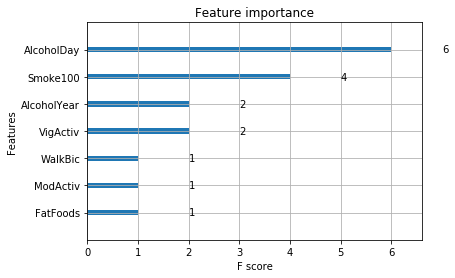

In [61]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [62]:
# save the model to disk
filename = 'GlycoHemoglobin_model.sav'
pickle.dump(xg_reg, open(filename, 'wb'))